🚦 Road Accident Severity Analysis & Visualization
📌 Project Overview

Road traffic accidents remain a major public safety concern, leading to loss of life, serious injuries, and economic impact. Understanding when, where, and under what conditions accidents occur can help identify high-risk patterns and support better road safety decisions.

This project focuses on exploratory data analysis (EDA) and visualization of a large real-world road accident dataset. The goal is to uncover meaningful patterns related to accident severity, time, environmental conditions, and road characteristics.

📊 Key Analysis Questions

This project aims to answer questions such as:

How are accidents distributed across different severity levels?

At what times of the day do accidents occur most frequently?

How do weather and lighting conditions influence accident severity?

Are rural accidents more severe than urban accidents?

Do higher speed limits correspond to more fatal accidents?

How has accident frequency changed over the years?

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import streamlit as st
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


Q1:- How to Load the dataset?

In [297]:
df=pd.read_csv("ACCIDENTDATA_PROJECT.csv")
df.isnull().sum()

Unnamed: 0                                           0
Accident_Index                                       0
Location_Easting_OSGR                              101
Location_Northing_OSGR                               0
Longitude                                          101
Latitude                                             0
Police_Force                                         0
Accident_Severity                                    0
Number_of_Vehicles                                   0
Number_of_Casualties                                 0
Date                                                 0
Day_of_Week                                          0
Time                                               104
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
1st_Road_Class                                       0
1st_Road_Number                                      0
Road_Type                                            0
Speed_limi

Q2:- Which variables contain excessive missing values that could reduce the reliability and interpretability of the analysis?”

ANS:-  These columns had very high missing values or overly granular information, making them unsuitable for meaningful visualization or pattern analysis.

In [298]:
df.drop(columns=["Special_Conditions_at_Site","Carriageway_Hazards","LSOA_of_Accident_Location"],inplace=True)
df.dropna(subset=['Time', 'Longitude', 'Latitude'], inplace=True)


Q3: How should missing categorical values related to road infrastructure and pedestrian control be handled to ensure accurate interpretation of accident context?

In [299]:
df['Junction_Control'] = df['Junction_Control'].fillna('None')
df['Pedestrian_Crossing-Human_Control'].fillna('None', inplace=True)
df['Pedestrian_Crossing-Physical_Facilities'].fillna('None', inplace=True)
df.isnull().sum()

Unnamed: 0                                     0
Accident_Index                                 0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Day_of_Week                                    0
Time                                           0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Control                               0
2nd_Road_Class      

In [300]:
df[['Junction_Control','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities','Urban_or_Rural_Area','Did_Police_Officer_Attend_Scene_of_Accident']].sample(5)


,Junction_Control,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
718683,Giveway or uncontrolled,None within 50 metres,No physical crossing within 50 meters,1,Yes
552418,None,None within 50 metres,No physical crossing within 50 meters,1,Yes
367564,Giveway or uncontrolled,None within 50 metres,Zebra crossing,1,Yes
470626,None,None within 50 metres,Pedestrian phase at traffic signal junction,1,Yes
778279,None,None within 50 metres,No physical crossing within 50 meters,1,No


Q4:- How can numeric codes in categorical variables be transformed into meaningful labels for clearer accident analysis?

In [301]:
df['Speed_limit'] = df['Speed_limit'].astype('category')
df['Urban_or_Rural_Area'] = df['Urban_or_Rural_Area'].map({1:'Urban', 2:'Rural'})

print(df[['Speed_limit',
          'Urban_or_Rural_Area']].sample(5))

        Speed_limit Urban_or_Rural_Area
1029708          60               Rural
1007980          30               Urban
847809           60               Rural
331662           40               Urban
473189           20               Urban


Q5:- Can the time variable be standardized to support accurate hourly accident analysis?

In [302]:
df['Time']=pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')
print(df['Time'].sample(5))

526553    1900-01-01 23:25:00
1020807   1900-01-01 08:11:00
107485    1900-01-01 02:10:00
147949    1900-01-01 19:00:00
652550    1900-01-01 06:55:00
Name: Time, dtype: datetime64[ns]


Q6:- How can environmental and road infrastructure variables be categorized to improve clarity and interpretability in accident analysis?

In [303]:
def simplify_weather(x):
    x=str(x).lower()
    if "fine" in x:
        return "Clear"
    elif "rain" in x:
        return "Rain"
    elif "snow" in x:
        return "Snow"
    elif "fog" in x or "mist" in x:
        return "Fog"
    elif "wind" in x:
        return "Wind"
    else:
        return "Other"
df["Weather_Report"]=df["Weather_Conditions"].apply(simplify_weather)
df.drop(columns=["Weather_Conditions"], inplace=True)

def simplify_lights(x):
    x=str(x).lower()
    if "daylight" in x:
        return "Daylight"
    elif "darkness" in x and "lit" in x:
        return "Lit_Dark"
    elif "darkness" in x:
        return "Unlit_Dark"
    else:
        return "Other"
df["Light_Report"]=df["Light_Conditions"].apply(simplify_lights)
df.drop(columns=["Light_Conditions"], inplace=True)  

def simplify_ped_phy(x):
    x=str(x).lower()
    if "no physical" in x or "none" in x:
        return "No crossing"
    elif "zebra" in x:
        return "Markings"
    elif "pelican" in x or "puffin" in x or "toucan" in x:
        return "Signalized"
    else:
        return "other"
df["Pedestrian_Crossing"]=df["Pedestrian_Crossing-Physical_Facilities"].apply(simplify_ped_phy)
df.drop(columns=["Pedestrian_Crossing-Physical_Facilities"], inplace=True)

def simplify_ped_human(x):
    x = str(x).lower()
    if "none" in x:
        return "None"
    else:
        return "Assisted"

df["Pedestrain_control"] = df["Pedestrian_Crossing-Human_Control"].apply(simplify_ped_human)
df.drop(columns=["Pedestrian_Crossing-Human_Control"], inplace=True)

print(df[['Pedestrain_control',
          'Pedestrian_Crossing',
          'Light_Report',
          'Weather_Report']].sample(5))


       Pedestrain_control Pedestrian_Crossing Light_Report Weather_Report
784450               None         No crossing     Daylight          Clear
141333               None         No crossing     Lit_Dark          Clear
744440               None            Markings     Daylight          Clear
64022                None         No crossing     Lit_Dark          Clear
295898               None               other     Daylight          Clear


Q7:- What is the distribution of accidents across severity categories after converting severity codes into descriptive labels?

In [304]:
severity_map = {
    1: 'Slight',
    2: 'Severe',
    3: 'Fatal'
}

df['Severity_Label'] = df['Accident_Severity'].map(severity_map)
severity_counts = df['Severity_Label'].value_counts()
print(severity_counts)


Severity_Label
Fatal     895912
Severe    138317
Slight     14141
Name: count, dtype: int64


Q8:- How does accident severity vary across different road speed limit categories?

In [305]:
def speed_group(x):
    if x <= 30: return 'Low (≤30)'
    elif x <= 50: return 'Medium (40–50)'
    else: return 'High (60+)'

df['Speed_Group'] = df['Speed_limit'].astype(int).apply(speed_group)
df['Speed_Group']

0          Low (≤30)
1          Low (≤30)
2          Low (≤30)
3          Low (≤30)
4          Low (≤30)
             ...    
1048570    Low (≤30)
1048571    Low (≤30)
1048572    Low (≤30)
1048573    Low (≤30)
1048574    Low (≤30)
Name: Speed_Group, Length: 1048370, dtype: object

Q9:-How can accident data be structured into meaningful time-based categories to better understand when accidents are most likely to occur?

In [306]:
df['Hour'] = df['Time'].dt.hour
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Weekday'] = pd.to_datetime(df['Date']).dt.day_name()

def day_period(h):
    if 0 <= h < 6: return 'Night'
    elif 6 <= h < 12: return 'Morning'
    elif 12 <= h < 18: return 'Afternoon'
    else: return 'Evening'

df['Day_Period'] = df['Hour'].apply(day_period)
df['Day_Period']

0          Afternoon
1          Afternoon
2              Night
3            Morning
4            Evening
             ...    
1048570      Morning
1048571      Morning
1048572      Morning
1048573    Afternoon
1048574      Evening
Name: Day_Period, Length: 1048370, dtype: object

Q10:- How does the number of vehicles involved in an accident relate to accident severity and overall accident patterns?

In [307]:
def vehicle_group(x):
    if x == 1: return 'Single'
    elif x == 2: return 'Two'
    else: return 'Multiple'

df['Vehicle_Group'] = df['Number_of_Vehicles'].apply(vehicle_group)
df['Vehicle_Group']

0            Single
1            Single
2               Two
3            Single
4            Single
             ...   
1048570         Two
1048571      Single
1048572      Single
1048573    Multiple
1048574         Two
Name: Vehicle_Group, Length: 1048370, dtype: object

VISUALISATION

Q1:- How are road traffic accidents distributed across different severity levels?

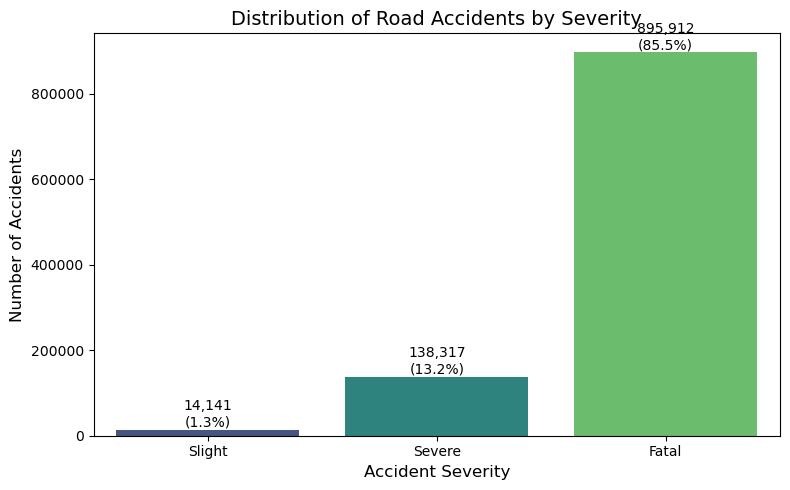

In [308]:
severity_counts = df['Severity_Label'].value_counts().reindex(['Slight', 'Severe', 'Fatal'])
total = severity_counts.sum()
percentages = (severity_counts / total) * 100

plt.figure(figsize=(8,5))
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="viridis")

plt.title("Distribution of Road Accidents by Severity", fontsize=14)
plt.xlabel("Accident Severity", fontsize=12)
plt.ylabel("Number of Accidents", fontsize=12)

for i, (count, pct) in enumerate(zip(severity_counts.values, percentages)):
    plt.text(i, count, f"{count:,}\n({pct:.1f}%)", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Q2:- Are fatal accidents more frequent on high-speed roads?

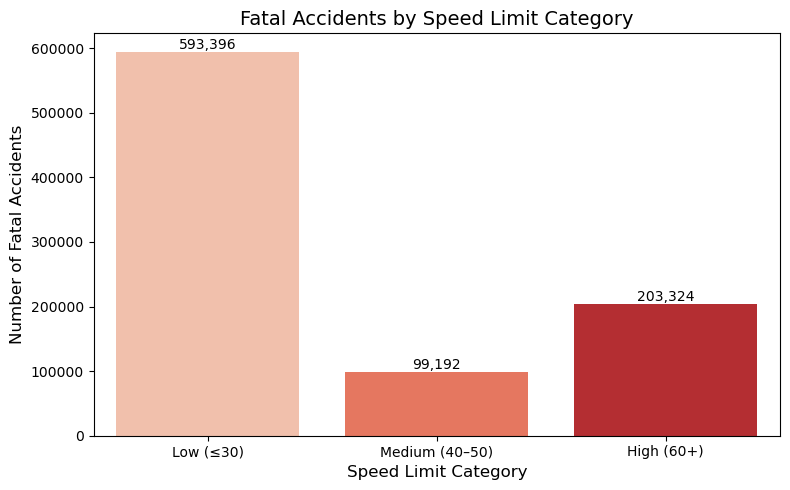

In [310]:
fatal_df = df[df['Severity_Label'] == 'Fatal']


fatal_speed_counts = fatal_df['Speed_Group'].value_counts().reindex(['Low (≤30)', 'Medium (40–50)', 'High (60+)'])


plt.figure(figsize=(8,5))
sns.barplot(x=fatal_speed_counts.index, y=fatal_speed_counts.values, palette='Reds')

plt.title("Fatal Accidents by Speed Limit Category", fontsize=14)
plt.xlabel("Speed Limit Category", fontsize=12)
plt.ylabel("Number of Fatal Accidents", fontsize=12)


for i, v in enumerate(fatal_speed_counts.values):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Q3: What proportion of accidents occur during different periods of the day?

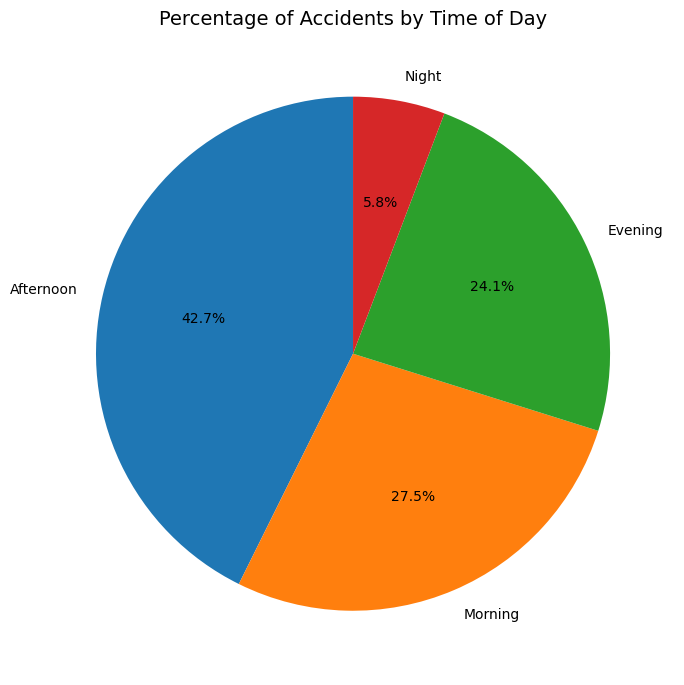

In [311]:
day_counts = df['Day_Period'].value_counts()


plt.figure(figsize=(7,7))
plt.pie(day_counts, 
        labels=day_counts.index, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=['#1f77b4','#ff7f0e','#2ca02c','#d62728'])

plt.title("Percentage of Accidents by Time of Day", fontsize=14)
plt.tight_layout()
plt.show()

Q4:- At what times of the day do different levels of accident severity most frequently occur?

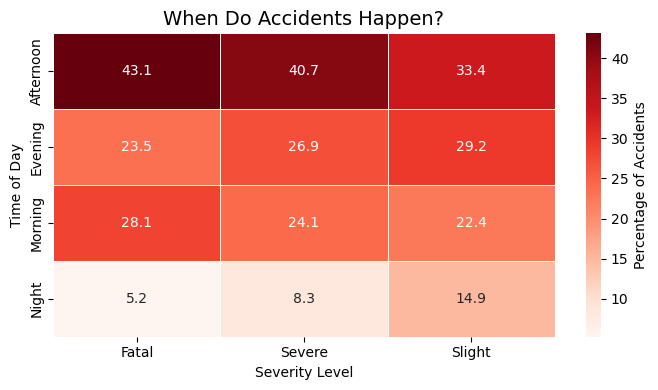

In [312]:
heat = pd.crosstab(df['Day_Period'], df['Severity_Label'], normalize='columns') * 100

plt.figure(figsize=(7,4))
sns.heatmap(heat,
            annot=True,
            fmt=".1f",
            cmap="Reds",
            linewidths=0.5,
            cbar_kws={'label': 'Percentage of Accidents'})

plt.title("When Do Accidents Happen?", fontsize=14)
plt.xlabel("Severity Level")
plt.ylabel("Time of Day")

plt.tight_layout()
plt.show()


Q5:-Under which combined weather and lighting conditions do different levels of accident severity most frequently occur?

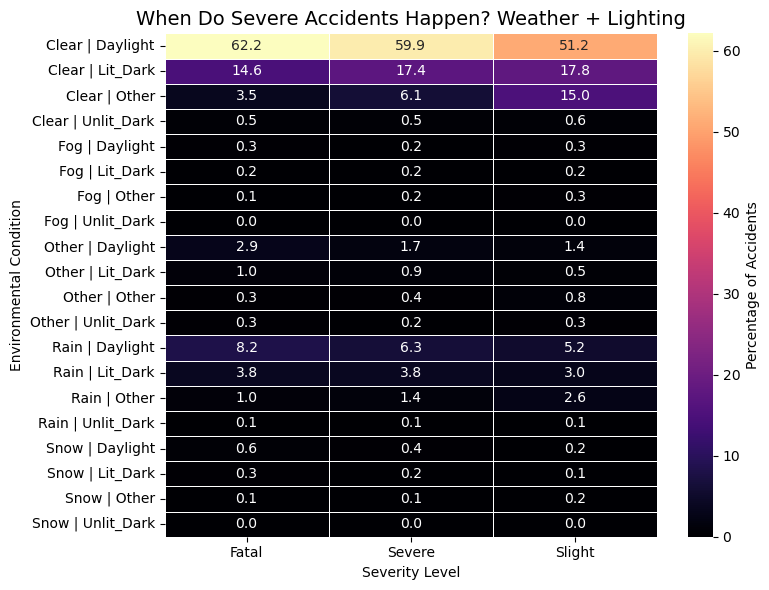

In [314]:
df['Env_Condition'] = df['Weather_Report'] + " | " + df['Light_Report']

combo = pd.crosstab(df['Env_Condition'], df['Severity_Label'], normalize='columns') * 100


plt.figure(figsize=(8,6))
sns.heatmap(combo,
            annot=True,
            fmt=".1f",
            cmap="magma",
            linewidths=0.5,
            cbar_kws={'label': 'Percentage of Accidents'})

plt.title("When Do Severe Accidents Happen? Weather + Lighting", fontsize=14)
plt.xlabel("Severity Level")
plt.ylabel("Environmental Condition")

plt.tight_layout()
plt.show()

Q6:- At what hours of the day do accidents occur most frequently?

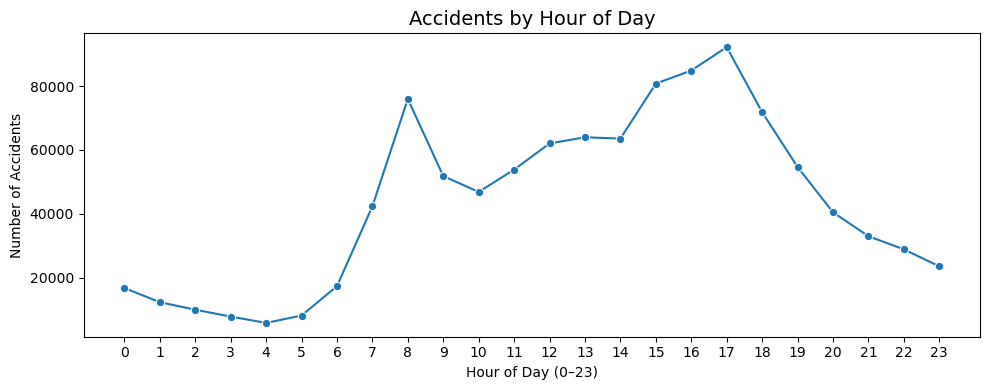

Top 5 hours with most accidents:
Hour
17    92207
16    84866
15    80771
8     75963
18    71843
Name: count, dtype: int64


In [316]:
hour_counts = df['Hour'].value_counts().sort_index()


plt.figure(figsize=(10,4))
sns.lineplot(x=hour_counts.index, y=hour_counts.values, marker='o')

plt.title("Accidents by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Accidents")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


print("Top 5 hours with most accidents:")
print(hour_counts.sort_values(ascending=False).head(5))

Q7:-What is the relationship between road type and accident severity?

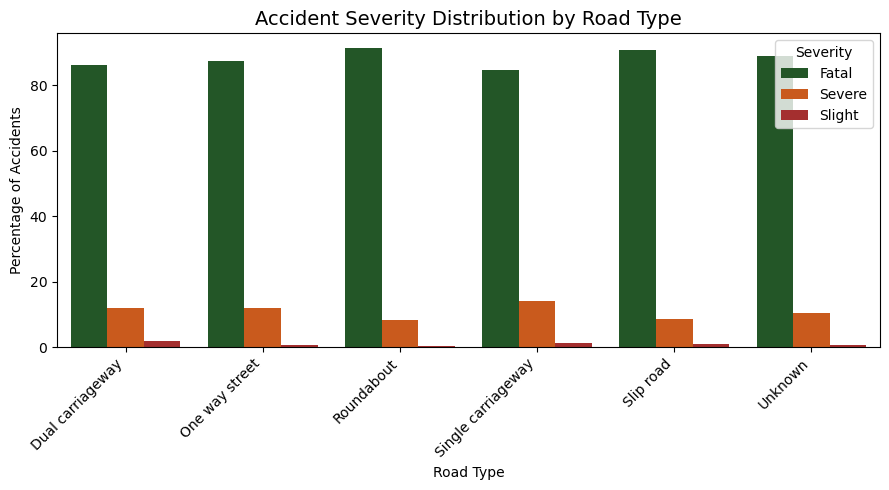

In [317]:
road_severity = pd.crosstab(df['Road_Type'], df['Severity_Label'], normalize='index') * 100
road_severity = road_severity.reset_index().melt(id_vars='Road_Type',
                                                var_name='Severity',
                                                value_name='Percentage')

plt.figure(figsize=(9,5))
sns.barplot(data=road_severity,
            x='Road_Type',
            y='Percentage',
            hue='Severity',
            palette=['#1b5e20','#e65100','#b71c1c'])

plt.title("Accident Severity Distribution by Road Type", fontsize=14)
plt.xlabel("Road Type")
plt.ylabel("Percentage of Accidents")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

Q8:- Are accidents in urban areas different in severity compared to rural areas?

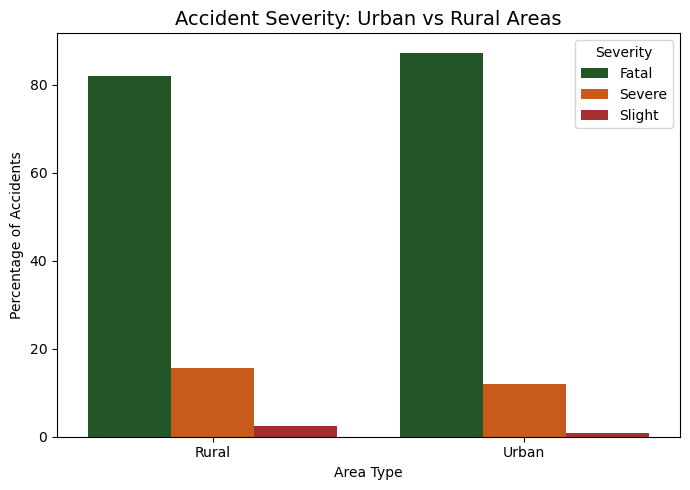

In [318]:
area_severity = pd.crosstab(df['Urban_or_Rural_Area'], df['Severity_Label'], normalize='index') * 100
area_severity = area_severity.reset_index().melt(id_vars='Urban_or_Rural_Area',
                                                var_name='Severity',
                                                value_name='Percentage')

plt.figure(figsize=(7,5))
sns.barplot(data=area_severity,
            x='Urban_or_Rural_Area',
            y='Percentage',
            hue='Severity',
            palette=['#1b5e20','#e65100','#b71c1c'])

plt.title("Accident Severity: Urban vs Rural Areas", fontsize=14)
plt.xlabel("Area Type")
plt.ylabel("Percentage of Accidents")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()


Q9:-Does the number of vehicles involved impact accident severity?

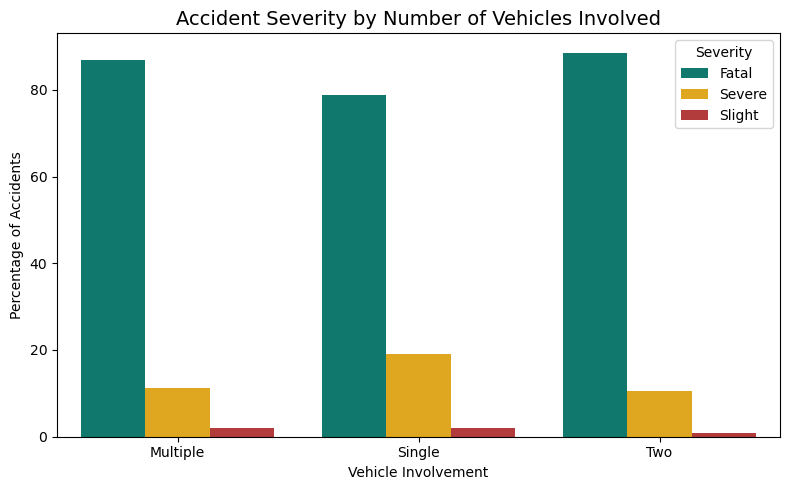

In [319]:
vehicle_severity = pd.crosstab(df['Vehicle_Group'], df['Severity_Label'], normalize='index') * 100
vehicle_severity = vehicle_severity.reset_index().melt(id_vars='Vehicle_Group',
                                                      var_name='Severity',
                                                      value_name='Percentage')

plt.figure(figsize=(8,5))
sns.barplot(data=vehicle_severity,
            x='Vehicle_Group',
            y='Percentage',
            hue='Severity',
            palette=['#00897B', '#FFB300', '#C62828'])

plt.title("Accident Severity by Number of Vehicles Involved", fontsize=14)
plt.xlabel("Vehicle Involvement")
plt.ylabel("Percentage of Accidents")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

Q10:- How have accident counts changed over the years?

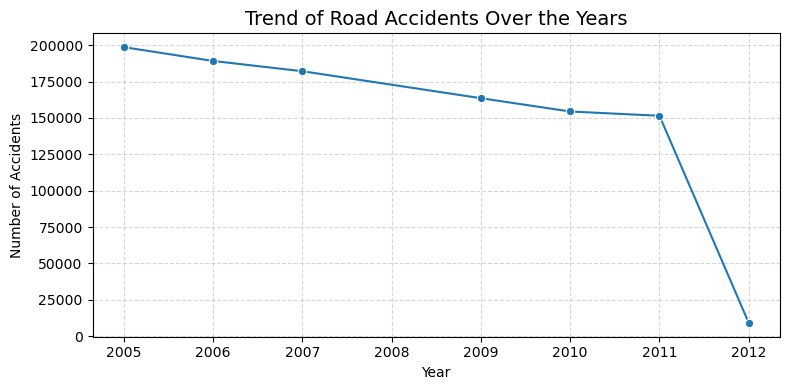

Year
2005    198637
2006    189126
2007    182080
2009    163537
2010    154406
2011    151462
2012      9122
Name: count, dtype: int64


In [320]:
year_counts = df['Year'].value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')

plt.title("Trend of Road Accidents Over the Years", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(year_counts)

🚀 Outcome

The final outcome of this project is a set of insightful visual analyses along with a Streamlit interactive dashboard that allows users to explore accident patterns dynamically. These findings can contribute to a better understanding of road safety risks and support data-driven decision-making.